# Assignment 3
Talia Arauzo
<br>CE 263 Scalable Spatial Analytics

### Import Data

Import necessary packages

In [1]:
import skmob
import pandas as pd
import json
from datetime import datetime
import warnings
warnings.filterwarnings(action='once')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

Import Prof. Gonzalez's location data

In [3]:
# Open json file with location data
with open('example/Location History.json') as json_file:
    data = json.load(json_file)
# Create DataFrame with location data
df = pd.DataFrame(data['locations'])

Parse and clean data to only include relevant information

In [4]:
# Convert timestampMs from seconds to datetime format
df['date'] = df['timestampMs'].apply(lambda x: datetime.fromtimestamp(int(x)/1000))

In [5]:
# Select dates to be extracted (12/01/19 - 12/08/19)
parse_df = df[(df['date'] > '2019-12-01') & (df['date'] < '2019-12-09')]

In [7]:
# Convert lat & lon to actual values
parse_df.loc[:, 'lat'] = parse_df.loc[:, 'latitudeE7']/10000000
parse_df.loc[:, 'lon'] = parse_df.loc[:, 'longitudeE7']/10000000

In [8]:
# Create column with timestamp in seconds
parse_df.loc[:, 'timestampMs'] = parse_df.loc[:, 'timestampMs'].astype(int)
parse_df.loc[:, 'timeSec'] = parse_df.loc[:, 'timestampMs']/1000

In [9]:
# Reset time such that first movement in parsed DataFrame occurs at time = 0s
parse_df.loc[:, 'timeSec'] = parse_df.loc[:, 'timeSec'] - parse_df.loc[:, 'timeSec'].iloc[0]

In [10]:
# Cleaned df
clean_df = parse_df[['timeSec', 'lon', 'lat','date']]

### Create Trajectory DataFrame

Create trajectory DataFrame using data from clean DataFrame

In [11]:
tdf = skmob.TrajDataFrame(clean_df, 
                          latitude='lat', 
                          datetime='date', 
                          longitude='lon')

Plot all trajectory points <b>without performing any data filtering</b>

In [13]:
# Create leaving_datetime column in order to plot_stops
tdf['leaving_datetime'] = tdf.datetime
# Plots user's stops (aka every single movement)
user0_map = tdf.plot_stops(zoom = 11)
# Plot user's trajectory
tdf.plot_trajectory(map_f = user0_map)

Trajectory properties <b>without performing any data filtering</b>

In [14]:
# Number of location points
print('# points: %s' %len(tdf))
# Time window of trajectories
print('time window: %s' 
      %(tdf.iloc[-1].datetime - tdf.iloc[0].datetime))

# points: 79
time window: 7 days 00:49:27.498000


## Part I

### 1. Focus on 1-2 days where a few locations were visited. Filter the data and extract stop locations. Present more than one map, changing the parameters used to detect the stops.

Import necessary packages

In [15]:
# Import filtering function
from skmob.preprocessing import filtering
# Import stop detection function
from skmob.preprocessing import detection

<b>Select 1-2 days</b> to analyze

In [16]:
# Select dates to be extracted (12/01/19 - 12/02/19)
tdf_1 = tdf[tdf['datetime'] < '2019-12-03']

In [17]:
# Number of location points
print('# points: %s' %len(tdf_1))
# Time window of trajectories
print('time window: %s' 
      %(tdf_1.iloc[-1].datetime - tdf_1.iloc[0].datetime))

# points: 47
time window: 1 days 18:24:28.328000


<b>Filter trajectory points</b> that are outliers / noise (none were actually filtered!)

In [18]:
# Filter trajectory DataFrame with 1-2 days of data
ftdf_1 = filtering.filter(tdf_1)

In [19]:
# Number of location points
print('# points: %s' %len(ftdf_1))
# Time window of trajectories
print('time window: %s' 
      %(ftdf_1.iloc[-1].datetime - ftdf_1.iloc[0].datetime))

# points: 47
time window: 1 days 18:24:28.328000


<b>Detect stops</b> along trajectory

In [20]:
# Drop leaving_datetime column so detection.stops can determine (only implement earlier for plotting purposes)
ftdf_1.drop(columns = ["leaving_datetime"], inplace = True)

In [24]:
# Create stop detection DataFrame
stdf_1 = detection.stops(ftdf_1, stop_radius_factor = 1, minutes_for_a_stop=20.0, 
                         spatial_radius_km=0.4, leaving_time=True)

In [25]:
# Number of location points
print('# points: %s' %len(stdf_1))
# Time window of trajectories
print('time window: %s' 
      %(stdf_1.iloc[-1].datetime - stdf_1.iloc[0].datetime))

# points: 7
time window: 1 days 13:40:02.001000


<b>Plot trajectory</b> of <b>filtered & stop detected</b> data

In [26]:
# Plot user's trajectory
smap_1 = stdf_1.plot_trajectory()
# Plot user's stops using data for 1-2 days
stdf_1.plot_stops(map_f = smap_1)

### 2. Count your trips during the 1-2 days. Then analyze & report the results of your entire time of observation. Plot the number of trips per day.

Import necessary packages

In [29]:
# Import individual mobility network
from skmob.measures.individual import individual_mobility_network

Create <b>individual mobility network for 1-2 days</b>

In [30]:
# Create individual mobility network
imn_df_1 = individual_mobility_network(stdf_1)

<b>Number of trips</b> for 1-2 days

In [31]:
# Calculate number of trips
n_trips_1 = sum(imn_df_1["n_trips"])
print("number of trips for 1-2 days:", n_trips_1)

number of trips for 1-2 days: 6


Parsed data properties

In [32]:
# Number of location points
print('# points: %s' %len(tdf))
# Time window of trajectories
print('time window: %s' 
      %(tdf.iloc[-1].datetime - tdf.iloc[0].datetime))

# points: 79
time window: 7 days 00:49:27.498000


<b>Filter trajectory points</b> that are outliers / noise (none were actually filtered!)

In [33]:
# Filter trajectory DataFrame with 7 days of data
ftdf = filtering.filter(tdf)

In [34]:
# Number of location points
print('# points: %s' %len(ftdf))
# Time window of trajectories
print('time window: %s' 
      %(ftdf.iloc[-1].datetime - ftdf.iloc[0].datetime))

# points: 79
time window: 7 days 00:49:27.498000


<b>Plot trajectory</b> of <b>filtered</b> data

In [36]:
# Plot user's stops using filtered data for 7 days
fmap = ftdf.plot_stops(zoom = 11)
# Plot user's trajectory
ftdf.plot_trajectory(map_f = fmap)

<b>Detect stops</b> along trajectory

In [37]:
# Drop leaving_datetime column so detection.stops can determine (only implement earlier for plotting purposes)
ftdf.drop(columns = ["leaving_datetime"], inplace = True)

In [38]:
# Create stop detection DataFrame
stdf = detection.stops(ftdf, stop_radius_factor = 1, minutes_for_a_stop=20.0, 
                         spatial_radius_km=0.4, leaving_time=True)

In [39]:
# Number of location points
print('# points: %s' %len(stdf))
# Time window of trajectories
print('time window: %s' 
      %(stdf.iloc[-1].datetime - stdf.iloc[0].datetime))

# points: 12
time window: 5 days 12:31:18.405000


<b>Plot trajectory</b> of <b>filtered, compressed, & stop detected</b> data

In [40]:
# Plot of trajectories with stop detection
smap = stdf.plot_trajectory()
stdf.plot_stops(map_f = smap)

Create <b>individual mobility network for 7 days</b> (actually 5 days after compression)

In [51]:
# Create individual mobility network
imn_df = individual_mobility_network(stdf)

<b>Number of trips</b> for 7 days (actually 5 days)

In [42]:
# Calculate number of trips
n_trips = sum(imn_df["n_trips"])
print("number of trips for 7 days:", n_trips)

number of trips for 7 days: 11


<b>Number of trips per day</b> for 7 days (actually 5 days)

In [52]:
# Merge individual mobility network DataFrame with stop detection DataFrame to know arrival & departure times
trips_df = imn_df.merge(stdf, left_on = ["lat_origin", "lng_origin"], right_on = ["lat", "lng"], how = "left")

In [58]:
# Add date column to stdf that contains trip departure date
trips_df["date"] = [i.date() for i in trips_df.leaving_datetime]

In [59]:
# Number of trips per day
trips_per_day = trips_df.groupby("date")["n_trips"].sum()

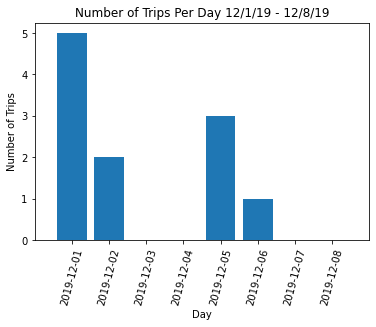

In [60]:
# Plot trips per day
plt.bar(trips_per_day.index, trips_per_day.values)
plt.xlabel("Day")
plt.ylabel("Number of Trips")
plt.title("Number of Trips Per Day 12/1/19 - 12/8/19")
plt.xticks(rotation = 75)
plt.xlim(datetime(2019, 11, 30), datetime(2019, 12, 9))
plt.xticks(pd.date_range(start="2019-12-01",end="2019-12-08"));

### 3. Calculate the distribution of stop durations.

In [66]:
# Calculate stop durations
trips_df["stop_duration"] = trips_df.leaving_datetime - trips_df.datetime

In [67]:
# Calculate stop durations in hours
trips_df["stop_duration_hr"] = trips_df.stop_duration / np.timedelta64(1, 'h')

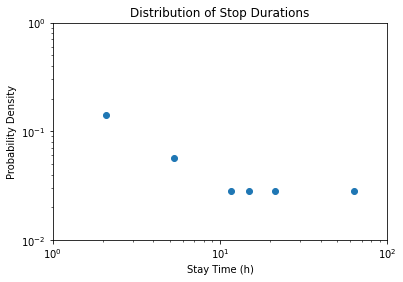

In [68]:
# Initialize plot
fig, ax = plt.subplots()
ax.set_xlabel("Stay Time (h)")
ax.set_ylabel("Probability Density")
ax.set_title("Distribution of Stop Durations")

# Determine probability density of stop durations
counts, binEdges = np.histogram(trips_df.stop_duration_hr, 20, density = True)
binCenters = (binEdges[:-1] + binEdges[1:]) / 2.
ax.errorbar(binCenters, counts, yerr = 0, fmt = "o")

# Set plot axes as logarithmic
ax.loglog()
ax.axis([1, 100, 0.01, 1])

plt.show()

### 4. Calculate the distribution of trip distances.

Import necessary packages

In [69]:
# Import Haversine distance calculating function
from skmob.utils.gislib import getDistanceByHaversine

Calculate Haversine distance between trips

In [70]:
# Starting and end point locations
start_loc_df = trips_df[["lat_origin", "lng_origin"]]
end_loc_df = trips_df[["lat_dest", "lng_dest"]]
trip_distance = []
# Calculate Haversine distance between locations
for i in np.arange(trips_df.shape[0]):
    start_loc = start_loc_df.loc[i, :]
    end_loc = end_loc_df.loc[i, :]
    trip_distance.append(getDistanceByHaversine(end_loc, start_loc))

In [71]:
# Add trip distance (km) to trips_df
trips_df["trip_distance_km"] = trip_distance

Plot distribution of trip distances

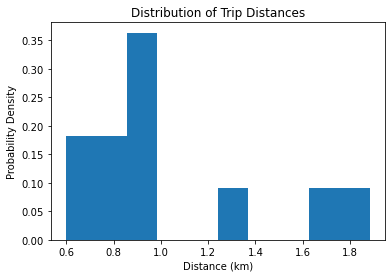

In [78]:
# Initialize plot
fig, ax = plt.subplots()
ax.set_xlabel("Distance (km)")
ax.set_ylabel("Probability Density")
ax.set_title("Distribution of Trip Distances")

# Determine probability density of stop durations
counts, binEdges = np.histogram(trips_df.trip_distance_km, 10)
binCenters = (binEdges[:-1] + binEdges[1:]) / 2.
bin_width = binEdges[1] - binEdges[0]

# Normalize counts to reflect density
probability = counts/sum(counts)

# Create plot
plt.bar(binCenters, probability, width = bin_width)
plt.show()

### 5. Calculate the distribution of trip speeds.

Calculate the trip speed
$$trip speed = \frac{trip distance}{stop duration}$$

In [80]:
# Add trip speed (km/h) to trip_df
trips_df["trip_speed"] = trips_df.trip_distance_km / trips_df.stop_duration_hr

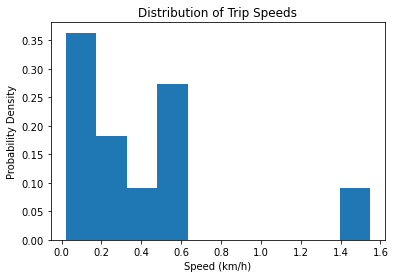

In [83]:
# Initialize plot
fig, ax = plt.subplots()
ax.set_xlabel("Speed (km/h)")
ax.set_ylabel("Probability Density")
ax.set_title("Distribution of Trip Speeds")

# Determine probability density of stop durations
counts, binEdges = np.histogram(trips_df.trip_speed, 10)
binCenters = (binEdges[:-1] + binEdges[1:]) / 2.
bin_width = binEdges[1] - binEdges[0]

# Normalize counts to reflect density
probability = counts/sum(counts)

# Create plot
plt.bar(binCenters, probability, width = bin_width)
plt.show()

### 6. Report the fraction of the total stays at each locations.

Import necessary packages

In [87]:
# Import trajectory clustering function
from skmob.preprocessing import clustering

Determine trajectory clusters which are equivalent to visited locations

In [124]:
# Determien trajectory clusters
cstdf = clustering.cluster(stdf, cluster_radius_km = 0.5)

/Users/taliaarauzo/miniconda3/envs/skmob/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


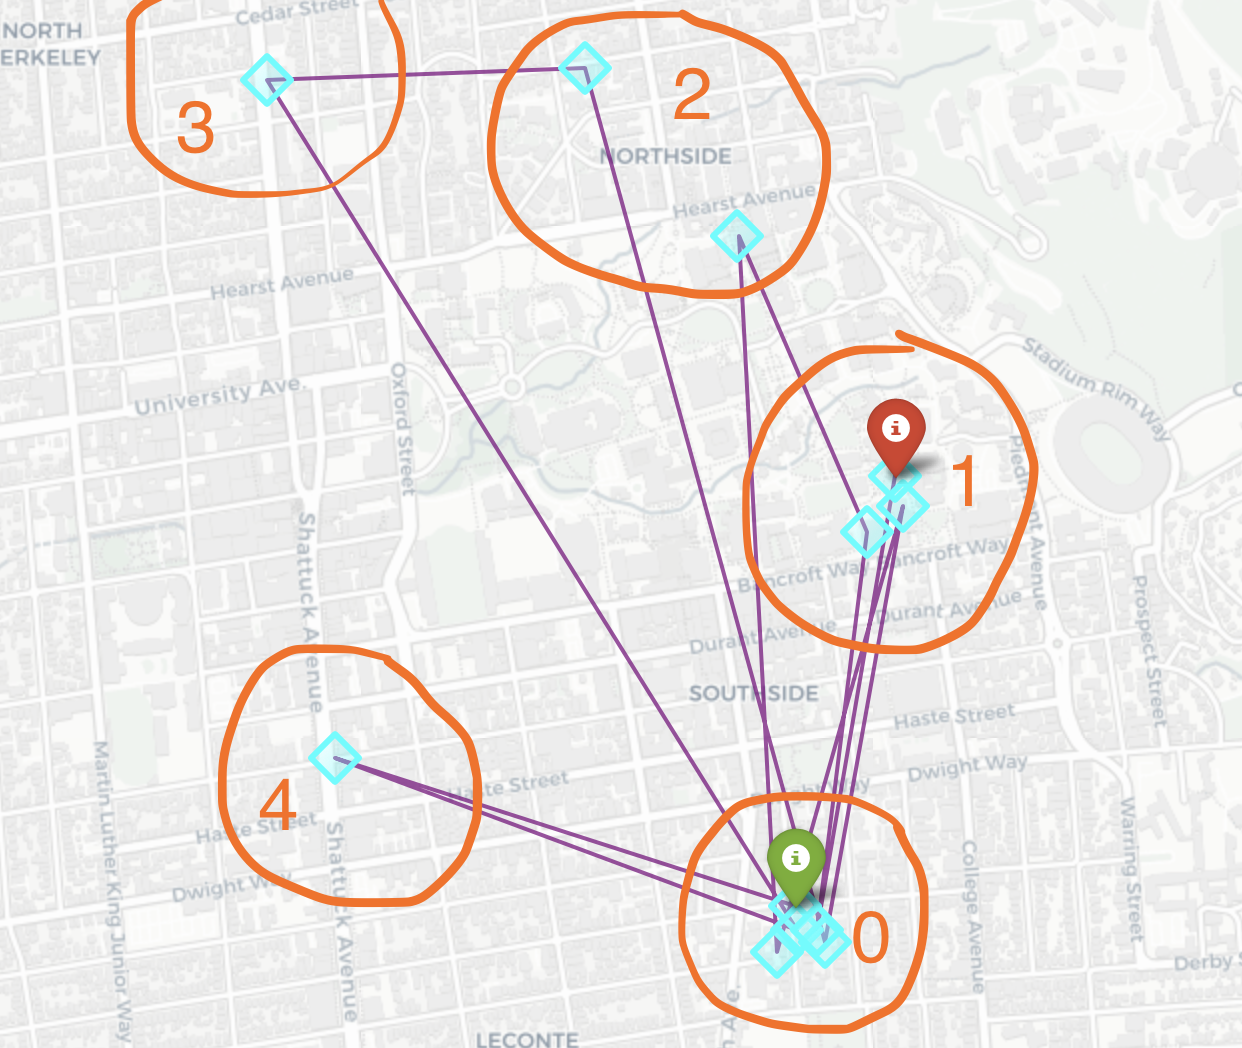

In [114]:
# Display image of clusters
from IPython.display import Image
Image("hw3_pt1/clusters.png", width = 600, height = 600)

Determine fraction of total stays in each location

In [157]:
cluster_df = cstdf[["cluster"]]
cluster_df = cluster_df.replace({0:1, 1:2, 2:3, 3:4, 4:5})
location_frequency = cluster_df.groupby("cluster").size()
location_fraction = location_frequency / sum(location_frequency)

Plot frequency of location visits, which is approximated by $P(L) \approx L^{-1}$

/Users/taliaarauzo/miniconda3/envs/skmob/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


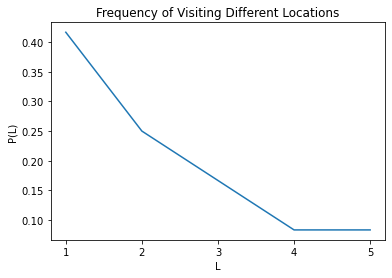

In [182]:
# Plot P(L)
plt.plot(location_fraction.index, location_fraction.values)
plt.xticks(np.arange(1, 6))
plt.xlabel("L")
plt.ylabel("P(L)")
plt.title("Frequency of Visiting Different Locations");

### 7. Determine the radius of gyration.

Import necessary packages

In [184]:
# Import the radius of gyration function
from skmob.measures.individual import radius_of_gyration

Calculate the radius of gyration

In [192]:
# Determine radius of gyration
rg = radius_of_gyration(stdf).loc[0][0]
print("radius of gyration: ", rg)

radius of gyration:  0.7258428148160471
